In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Classification

In [64]:
classification_results = pd.read_csv('../outputs/results/results_classification.csv')
classification_results.sample(2)

,Dataset,Noise,Model,Accuracy,F1 Score,Precision,Recall
316,20 Newsgroups Full,ShuffleSentencesNoise,RandomForest,0.37,0.35,0.56,0.37
366,20 Newsgroups LLM labels,ReplaceWithSynonymsNoise,SVM,0.08,0.11,0.92,0.08


### Zero Shot

In [26]:
zero_shot = classification_results[classification_results['Model'].isin(['LLMClassifier', 'TARSZeroShot'])]

In [27]:
zero_shot_bbc = zero_shot[zero_shot['Dataset'] == 'BBC News Full']
zero_shot_ag = zero_shot[zero_shot['Dataset'] == 'AG News Full']
zero_shot_20 = zero_shot[zero_shot['Dataset'] == '20 Newsgroups Full']
len(zero_shot_bbc), len(zero_shot_ag), len(zero_shot_20)

(14, 14, 14)

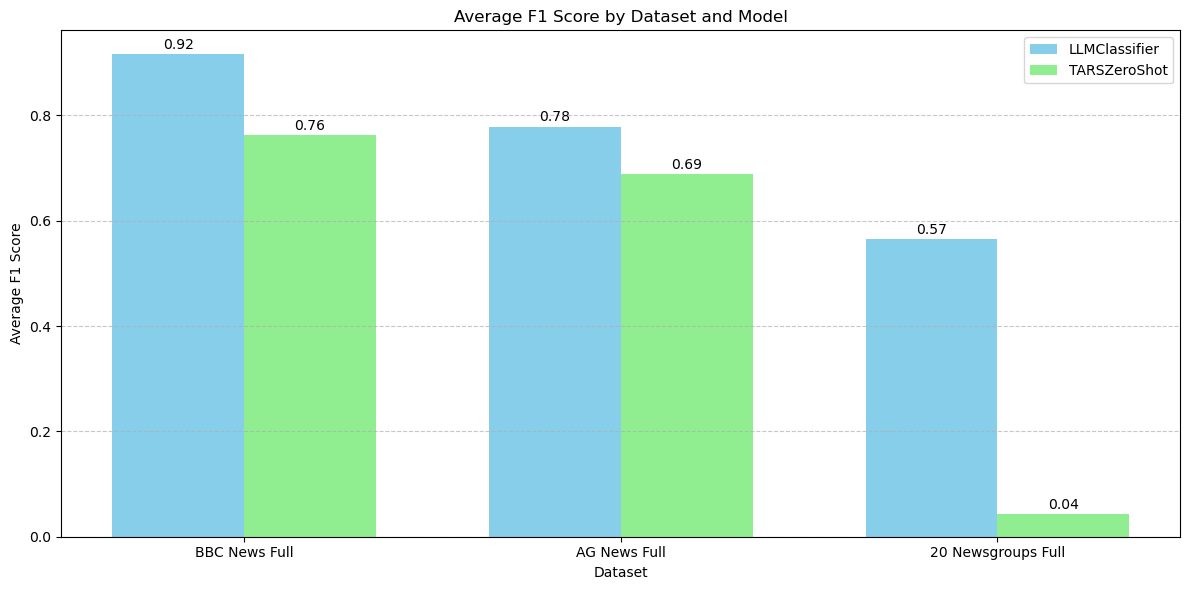

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_avg_f1_by_model_dataset(zero_shot, datasets_order=None):
    """
    Creates a grouped bar chart showing the average F1 scores by dataset and model,
    ensuring that scores align with the provided dataset order.
    
    Parameters:
    -----------
    zero_shot : pandas DataFrame
        DataFrame containing the zero-shot classification results
    datasets_order : list, optional
        List specifying the order of datasets to display
    """
    # Calculate average f1 score by dataset and model
    avg_f1 = zero_shot.groupby(['Dataset', 'Model'])['F1 Score'].mean().reset_index()

    # Pivot so each model is a column
    pivot_df = avg_f1.pivot(index='Dataset', columns='Model', values='F1 Score')

    # Determine dataset order
    if datasets_order is None:
        datasets = list(pivot_df.index)
    else:
        datasets = datasets_order

    # Reindex to ensure correct order and handle missing datasets
    pivot_df = pivot_df.reindex(datasets)

    # X positions
    x = np.arange(len(datasets))
    bar_width = 0.35

    # Extract values
    llm_scores = pivot_df['LLMClassifier'].values
    tars_scores = pivot_df['TARSZeroShot'].values

    # Plot bars
    plt.figure(figsize=(12, 6))
    plt.bar(x - bar_width/2, llm_scores, width=bar_width, label='LLMClassifier', color='skyblue')
    plt.bar(x + bar_width/2, tars_scores, width=bar_width, label='TARSZeroShot', color='lightgreen')

    # Labels and title
    plt.xlabel('Dataset')
    plt.ylabel('Average F1 Score')
    plt.title('Average F1 Score by Dataset and Model')
    plt.xticks(x, datasets)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add values on top of bars
    for i, v in enumerate(llm_scores):
        plt.text(i - bar_width/2, v + 0.01, f'{v:.2f}', ha='center')
    for i, v in enumerate(tars_scores):
        plt.text(i + bar_width/2, v + 0.01, f'{v:.2f}', ha='center')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_avg_f1_by_model_dataset(zero_shot, datasets_order=['BBC News Full', 'AG News Full', '20 Newsgroups Full'])


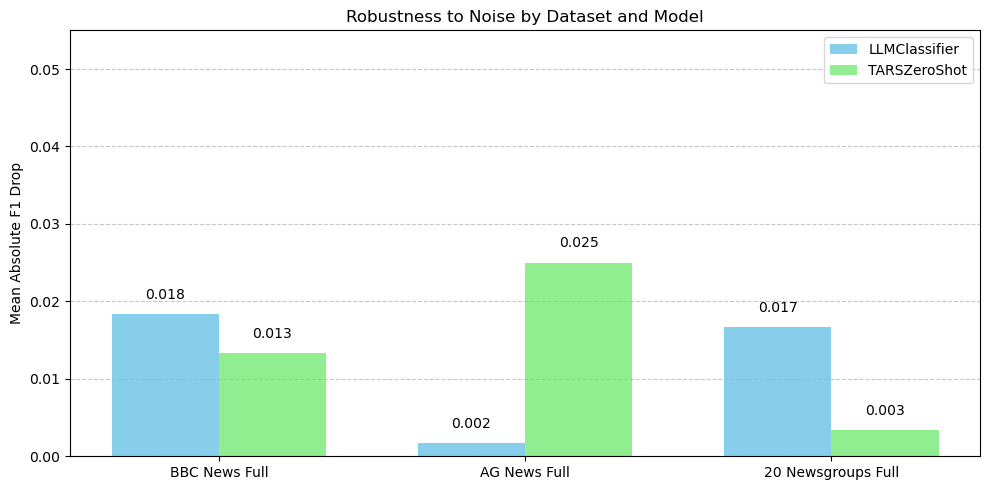

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_robustness_by_dataset(zero_shot, datasets_order=None):
    """
    Plots mean absolute F1 drop (robustness) per dataset and model,
    ensuring drops align with the provided dataset order.
    
    Parameters:
    - zero_shot: pandas DataFrame with ['Dataset', 'Model', 'Noise', 'F1 Score']
    - datasets_order: optional list to specify dataset order
    """
    # Compute mean absolute drop per dataset and model
    records = []
    models = zero_shot['Model'].unique()

    # Determine dataset order
    all_datasets = sorted(zero_shot['Dataset'].unique())
    datasets = all_datasets if datasets_order is None else datasets_order

    for model in models:
        # Get clean F1 per dataset
        clean = zero_shot[zero_shot['Noise']=='NoNoise']
        clean = clean[clean['Model']==model].set_index('Dataset')['F1 Score']
        for dataset in datasets:
            if dataset not in clean.index:
                continue
            clean_val = clean.loc[dataset]
            noisy = zero_shot[(zero_shot['Model']==model) &
                              (zero_shot['Dataset']==dataset) &
                              (zero_shot['Noise']!='NoNoise')]['F1 Score']
            drop = np.mean(np.abs(noisy - clean_val)) if len(noisy) else 0
            records.append({'Dataset': dataset, 'Model': model, 'MeanAbsDrop': drop})

    drop_df = pd.DataFrame(records)
    pivot = drop_df.pivot(index='Dataset', columns='Model', values='MeanAbsDrop').reindex(datasets)

    # Plot
    x = np.arange(len(datasets))
    bar_width = 0.35
    llm = pivot['LLMClassifier'].values
    tars = pivot['TARSZeroShot'].values

    plt.figure(figsize=(10, 5))
    plt.bar(x - bar_width/2, llm, bar_width, label='LLMClassifier', color='skyblue')
    plt.bar(x + bar_width/2, tars, bar_width, label='TARSZeroShot', color='lightgreen')

    for i, (l, t) in enumerate(zip(llm, tars)):
        plt.text(i - bar_width/2, l + 0.002, f'{l:.3f}', ha='center')
        plt.text(i + bar_width/2, t + 0.002, f'{t:.3f}', ha='center')

    plt.xticks(x, datasets)
    plt.ylabel('Mean Absolute F1 Drop')
    plt.title('Robustness to Noise by Dataset and Model')
    plt.ylim(0, max(np.nanmax(llm), np.nanmax(tars)) + 0.03)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_robustness_by_dataset(zero_shot, datasets_order=['BBC News Full', 'AG News Full', '20 Newsgroups Full'])


## Supervised Classification

In [55]:
supervised_class = classification_results[~classification_results['Model'].isin(['LLMClassifier', 'TARSZeroShot'])]
supervised_class_full = supervised_class[supervised_class['Dataset'].isin(['BBC News Full', 'AG News Full', '20 Newsgroups Full'])]
supervised_class_llm = supervised_class[supervised_class['Dataset'].isin(['BBC News LLM labels', 'AG News LLM labels', '20 Newsgroups LLM labels'])]

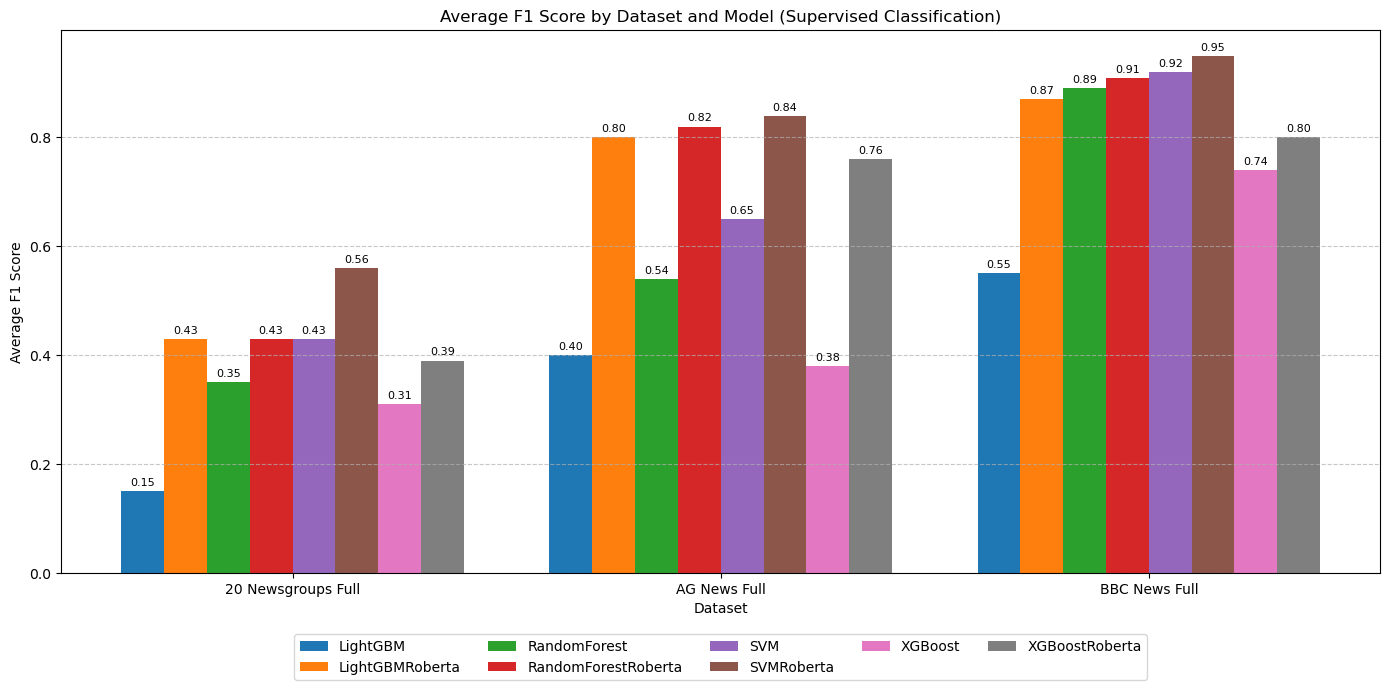

In [56]:
def plot_avg_f1_by_model_dataset(data, datasets_order=None, title=None):
    """
    Creates a grouped bar chart showing the average F1 scores by dataset and model,
    supporting any number of models.
    
    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing classification results
    datasets_order : list, optional
        List specifying the order of datasets to display
    title : str, optional
        Title for the chart
    """
    # Calculate average f1 score by dataset and model
    avg_f1 = data.groupby(['Dataset', 'Model'])['F1 Score'].mean().reset_index()
    
    # Pivot so each model is a column
    pivot_df = avg_f1.pivot(index='Dataset', columns='Model', values='F1 Score')
    
    # Determine dataset order
    if datasets_order is None:
        datasets = list(pivot_df.index)
    else:
        # Filter to only include datasets that exist in the data
        datasets = [d for d in datasets_order if d in pivot_df.index]
    
    # Reindex to ensure correct order and handle missing datasets
    pivot_df = pivot_df.reindex(datasets)
    
    # Get models
    models = list(pivot_df.columns)
    num_models = len(models)
    
    # Create colormap
    colors = plt.cm.tab10.colors[:num_models]
    
    # X positions
    x = np.arange(len(datasets))
    bar_width = 0.8 / num_models  # Adjust width based on number of models
    
    # Plot bars
    plt.figure(figsize=(14, 7))
    bars = []
    
    for i, model in enumerate(models):
        position = x + (i - (num_models-1)/2) * bar_width
        bar = plt.bar(position, pivot_df[model].values, width=bar_width, 
                      label=model, color=colors[i % len(colors)])
        bars.append(bar)
        
        # Add values on top of bars
        for j, v in enumerate(pivot_df[model].values):
            if not np.isnan(v):  # Only add text if value is not NaN
                plt.text(position[j], v + 0.01, f'{v:.2f}', ha='center', fontsize=8)
    
    # Labels and title
    plt.xlabel('Dataset')
    plt.ylabel('Average F1 Score')
    plt.title(title or 'Average F1 Score by Dataset and Model')
    plt.xticks(x, datasets)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=min(5, num_models))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Use it with supervised class data
plot_avg_f1_by_model_dataset(
    supervised_class_full[supervised_class_full['Noise'] == 'NoNoise'], 
    title='Average F1 Score by Dataset and Model (Supervised Classification)'
)


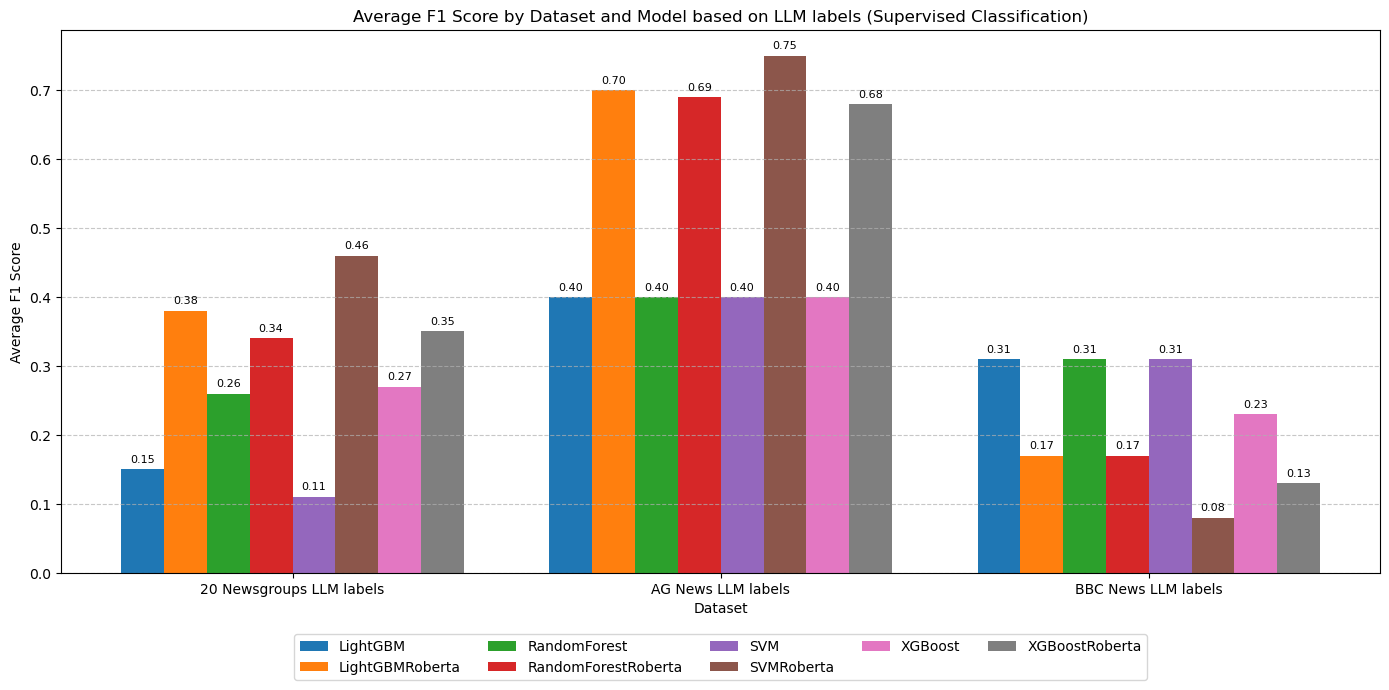

In [58]:
plot_avg_f1_by_model_dataset(
    supervised_class_llm[supervised_class_llm['Noise'] == 'NoNoise'], 
    title='Average F1 Score by Dataset and Model based on LLM labels (Supervised Classification)'
)

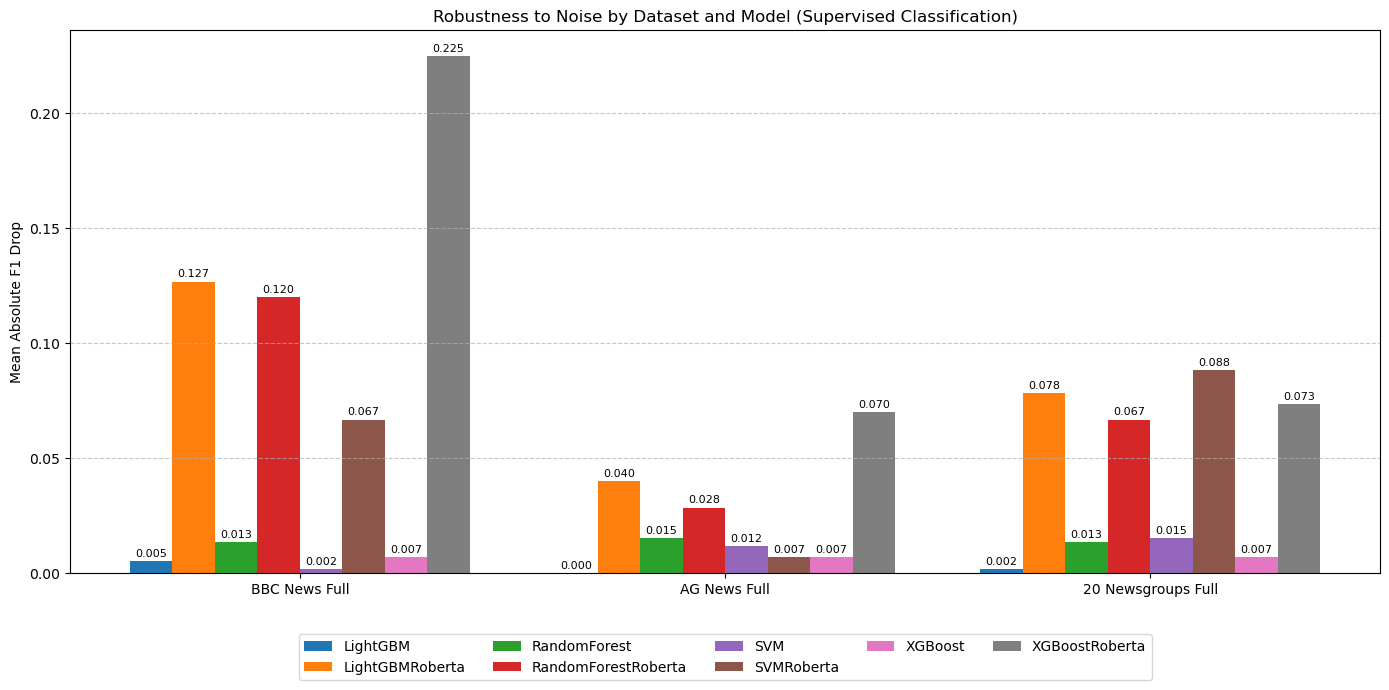

In [61]:
def plot_robustness_by_dataset_supervised(data, datasets_order=None, title=None):
    """
    Plots mean absolute F1 drop (robustness) per dataset and model for supervised models,
    supporting multiple models.
    
    Parameters:
    - data: pandas DataFrame with ['Dataset', 'Model', 'Noise', 'F1 Score']
    - datasets_order: optional list to specify dataset order
    - title: optional string for chart title
    """
    # Compute mean absolute drop per dataset and model
    records = []
    models = data['Model'].unique()

    # Determine dataset order
    all_datasets = sorted(data['Dataset'].unique())
    datasets = all_datasets if datasets_order is None else [d for d in datasets_order if d in all_datasets]

    for model in models:
        # Get clean F1 per dataset
        clean = data[(data['Noise']=='NoNoise') & (data['Model']==model)]
        clean = clean.set_index('Dataset')['F1 Score']
        
        for dataset in datasets:
            if dataset not in clean.index:
                continue
            clean_val = clean.loc[dataset]
            noisy = data[(data['Model']==model) &
                         (data['Dataset']==dataset) &
                         (data['Noise']!='NoNoise')]['F1 Score']
            drop = np.mean(np.abs(noisy - clean_val)) if len(noisy) else 0
            records.append({'Dataset': dataset, 'Model': model, 'MeanAbsDrop': drop})

    drop_df = pd.DataFrame(records)
    
    # Pivot so each model is a column
    pivot = drop_df.pivot(index='Dataset', columns='Model', values='MeanAbsDrop').reindex(datasets)
    
    # Plot
    plt.figure(figsize=(14, 7))
    
    # X positions
    x = np.arange(len(datasets))
    num_models = len(models)
    bar_width = 0.8 / num_models
    
    # Colors
    colors = plt.cm.tab10.colors[:num_models]
    
    # Plot bars for each model
    for i, model in enumerate(pivot.columns):
        position = x + (i - (num_models-1)/2) * bar_width
        values = pivot[model].values
        plt.bar(position, values, bar_width, label=model, color=colors[i % len(colors)])
        
        # Add text labels
        for j, value in enumerate(values):
            if not np.isnan(value):
                plt.text(position[j], value + 0.002, f'{value:.3f}', ha='center', fontsize=8)
    
    plt.xticks(x, datasets)
    plt.ylabel('Mean Absolute F1 Drop')
    plt.title(title or 'Robustness to Noise by Dataset and Model (Supervised)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=min(5, num_models))
    plt.tight_layout()
    plt.show()

# Use with supervised classification data
plot_robustness_by_dataset_supervised(
    supervised_class_full, 
    datasets_order=['BBC News Full', 'AG News Full', '20 Newsgroups Full'],
    title='Robustness to Noise by Dataset and Model (Supervised Classification)'
)

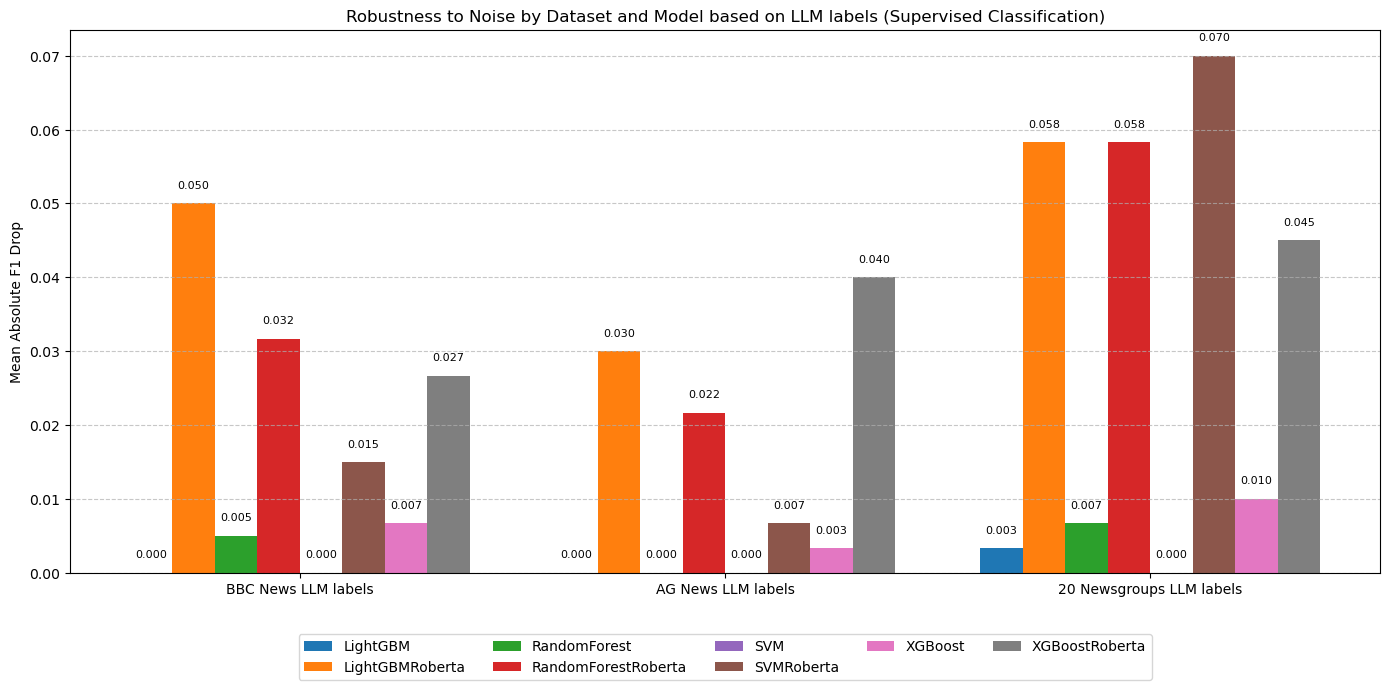

In [69]:
plot_robustness_by_dataset_supervised(
    supervised_class_llm, 
    datasets_order=['BBC News LLM labels', 'AG News LLM labels', '20 Newsgroups LLM labels'],
    title='Robustness to Noise by Dataset and Model based on LLM labels (Supervised Classification)'
)

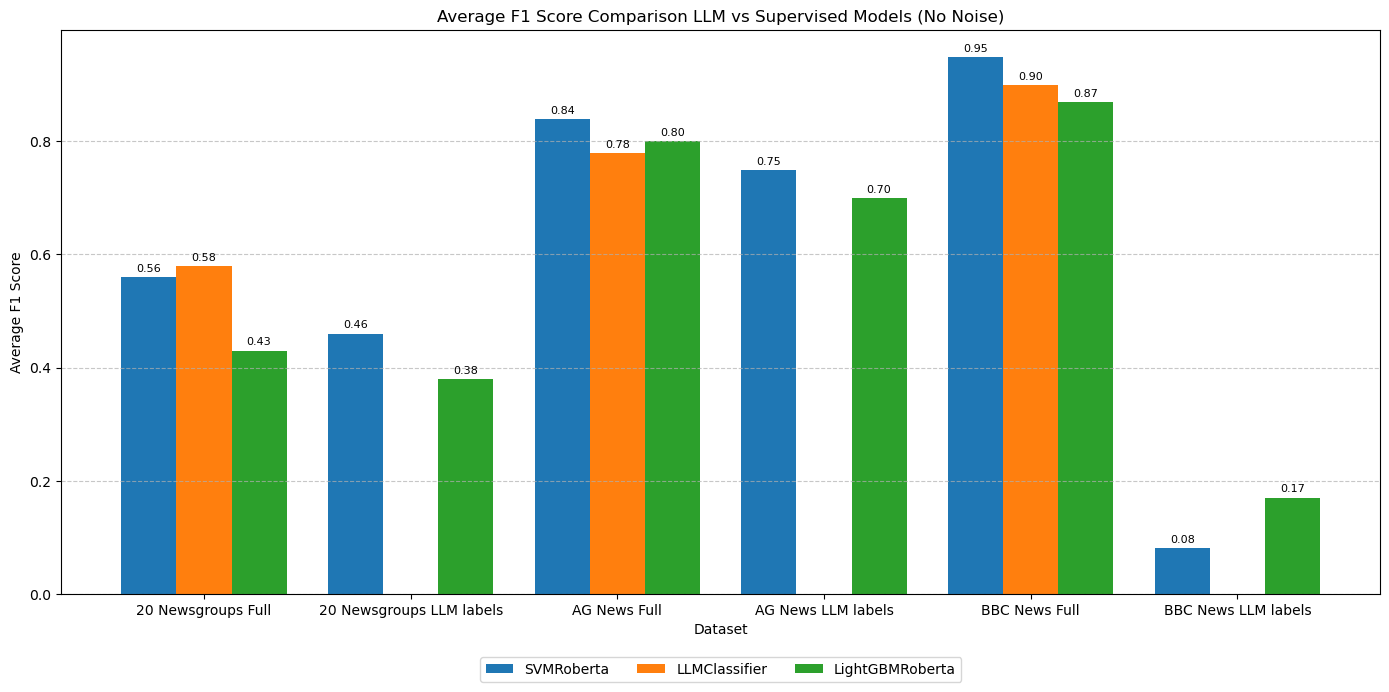

In [73]:
def plot_avg_f1_by_model_dataset(data, datasets_order=None, title=None):
    """
    Creates a grouped bar chart showing the average F1 scores by dataset and model,
    supporting any number of models.
    
    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing classification results
    datasets_order : list, optional
        List specifying the order of datasets to display
    title : str, optional
        Title for the chart
    """
    # Calculate average f1 score by dataset and model
    avg_f1 = data.groupby(['Dataset', 'Model'])['F1 Score'].mean().reset_index()
    
    # Pivot so each model is a column
    pivot_df = avg_f1.pivot(index='Dataset', columns='Model', values='F1 Score')
    
    # Determine dataset order
    if datasets_order is None:
        datasets = list(pivot_df.index)
    else:
        # Filter to only include datasets that exist in the data
        datasets = [d for d in datasets_order if d in pivot_df.index]
    
    # Reindex to ensure correct order and handle missing datasets
    pivot_df = pivot_df.reindex(datasets)
    
    # Get models
    models = ['SVMRoberta', 'LLMClassifier', 'LightGBMRoberta']
    num_models = len(models)
    
    # Create colormap
    colors = plt.cm.tab10.colors[:num_models]
    
    # X positions
    x = np.arange(len(datasets))
    bar_width = 0.8 / num_models  # Adjust width based on number of models
    
    # Plot bars
    plt.figure(figsize=(14, 7))
    bars = []
    
    for i, model in enumerate(models):
        position = x + (i - (num_models-1)/2) * bar_width
        bar = plt.bar(position, pivot_df[model].values, width=bar_width, 
                      label=model, color=colors[i % len(colors)])
        bars.append(bar)
        
        # Add values on top of bars
        for j, v in enumerate(pivot_df[model].values):
            if not np.isnan(v):  # Only add text if value is not NaN
                plt.text(position[j], v + 0.01, f'{v:.2f}', ha='center', fontsize=8)
    
    # Labels and title
    plt.xlabel('Dataset')
    plt.ylabel('Average F1 Score')
    plt.title(title or 'Average F1 Score by Dataset and Model')
    plt.xticks(x, datasets)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=min(5, num_models))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Use it with supervised class data
plot_avg_f1_by_model_dataset(
    classification_results[classification_results['Noise'] == 'NoNoise'], 
    title='Average F1 Score Comparison LLM vs Supervised Models (No Noise)'
)


## Topic Modeling

In [74]:
topics_results = pd.read_csv('../outputs/results/results_topic_modelling.csv')
topics_results.sample(2)

,Dataset,Noise,Model,ARI Score,Topics Coherence,Cosine Similarity,Reconstruction Error
24,AG News Full,AddRandomWordsNoise,LDA_4,0.0,0.38,0.35,NaN
4,20 Newsgroups Full,AddRandomWordsNoise,LSI_4,0.0,0.59,0.66,NaN


In [75]:
def plot_topic_modeling_metrics(data, metrics=None, group_by='Model', filter_dataset=None, filter_noise=None):
    """
    Creates bar plots for topic modeling metrics (ARI, Topic Coherence, Cosine Similarity).
    
    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing topic modeling results
    metrics : list, optional
        List of metrics to plot (default: ['ARI Score', 'Topics Coherence', 'Cosine Similarity'])
    group_by : str, default='Model'
        Column to group by (e.g., 'Model', 'Dataset', 'Noise')
    filter_dataset : str or list, optional
        Dataset(s) to filter by
    filter_noise : str or list, optional
        Noise type(s) to filter by
    """
    # Default metrics
    if metrics is None:
        metrics = ['ARI Score', 'Topics Coherence', 'Cosine Similarity']
    
    # Filter data if requested
    filtered_data = data.copy()
    if filter_dataset:
        if isinstance(filter_dataset, str):
            filter_dataset = [filter_dataset]
        filtered_data = filtered_data[filtered_data['Dataset'].isin(filter_dataset)]
    
    if filter_noise:
        if isinstance(filter_noise, str):
            filter_noise = [filter_noise]
        filtered_data = filtered_data[filtered_data['Noise'].isin(filter_noise)]
    
    # Get unique values for grouping
    groups = sorted(filtered_data[group_by].unique())
    
    # Set up the figure
    n_metrics = len(metrics)
    fig_width = 6 * n_metrics
    fig_height = 8
    
    fig, axes = plt.subplots(1, n_metrics, figsize=(fig_width, fig_height))
    if n_metrics == 1:
        axes = [axes]  # Convert to list for consistent indexing
    
    # Plot each metric
    for i, m in enumerate(metrics):
        # Calculate average metric by group
        avg_metric = filtered_data.groupby([group_by])[m].mean().reset_index()
        
        # Sort by metric value for better visualization
        avg_metric = avg_metric.sort_values(by=m, ascending=False)
        
        # Create color map
        colors = plt.cm.tab10.colors[:len(groups)]
        
        # Plot bars
        ax = axes[i]
        bars = ax.bar(avg_metric[group_by], avg_metric[m], color=colors)
        
        # Add values on top of bars
        for bar, value in zip(bars, avg_metric[m]):
            ax.text(bar.get_x() + bar.get_width()/2, value + 0.01, f'{value:.2f}', 
                    ha='center', va='bottom', fontsize=9)
        
        # Labels and title
        ax.set_xlabel(group_by)
        ax.set_ylabel(m)
        ax.set_title(f'Average {m} by {group_by}')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Rotate x-tick labels if needed
        if len(groups) > 3:
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

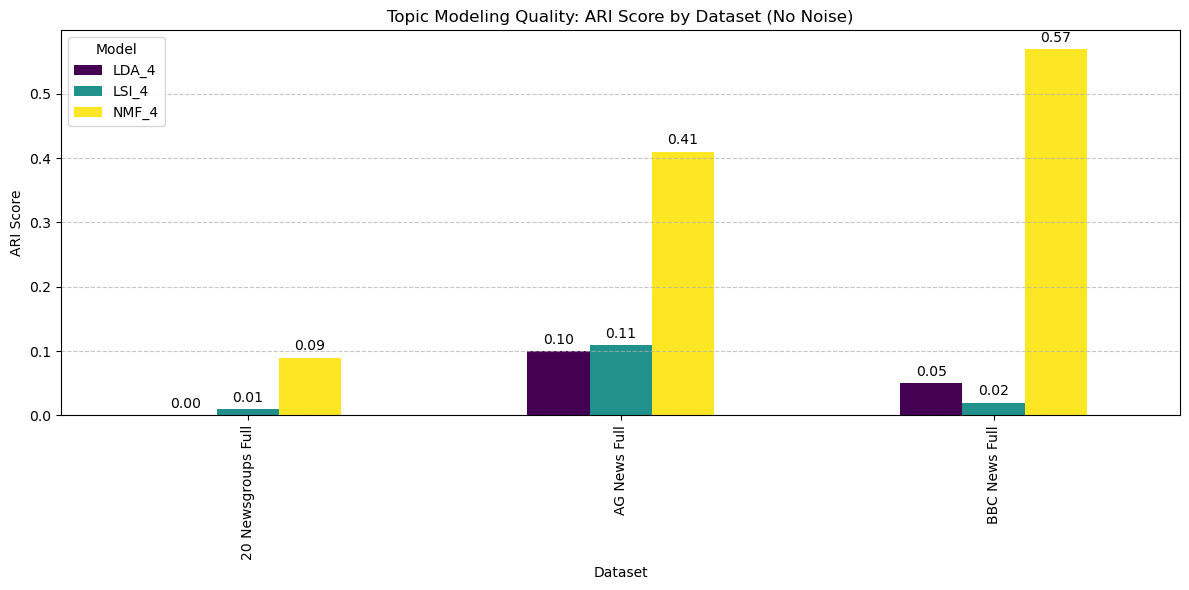

In [77]:

# Plot topic modeling ARI scores by dataset and model
def plot_topic_modeling_ari(data=None, title=None):
    """
    Creates a bar plot showing the average ARI scores by dataset and model,
    filtered for NoNoise condition only.
    
    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing topic modeling results
    title : str, optional
        Title for the chart
    """
    if data is None:
        data = topics_results
        
    # Filter for NoNoise condition to get baseline performance
    clean_data = data[data['Noise'] == 'NoNoise']
    
    # Calculate average ARI score by dataset and model
    avg_ari = clean_data.groupby(['Dataset', 'Model'])['ARI Score'].mean().reset_index()
    
    # Pivot for plotting
    pivot_df = avg_ari.pivot(index='Dataset', columns='Model', values='ARI Score')
    
    # Set up plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot as grouped bar chart
    pivot_df.plot(kind='bar', ax=ax, colormap='viridis')
    
    # Enhance plot
    plt.title(title or 'Average ARI Score by Dataset and Topic Model')
    plt.xlabel('Dataset')
    plt.ylabel('ARI Score')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Model')
    
    # Add values on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)
        
    plt.tight_layout()
    plt.show()
    
    return pivot_df

# Execute the function
ari_by_dataset_model = plot_topic_modeling_ari(title='Topic Modeling Quality: ARI Score by Dataset (No Noise)')

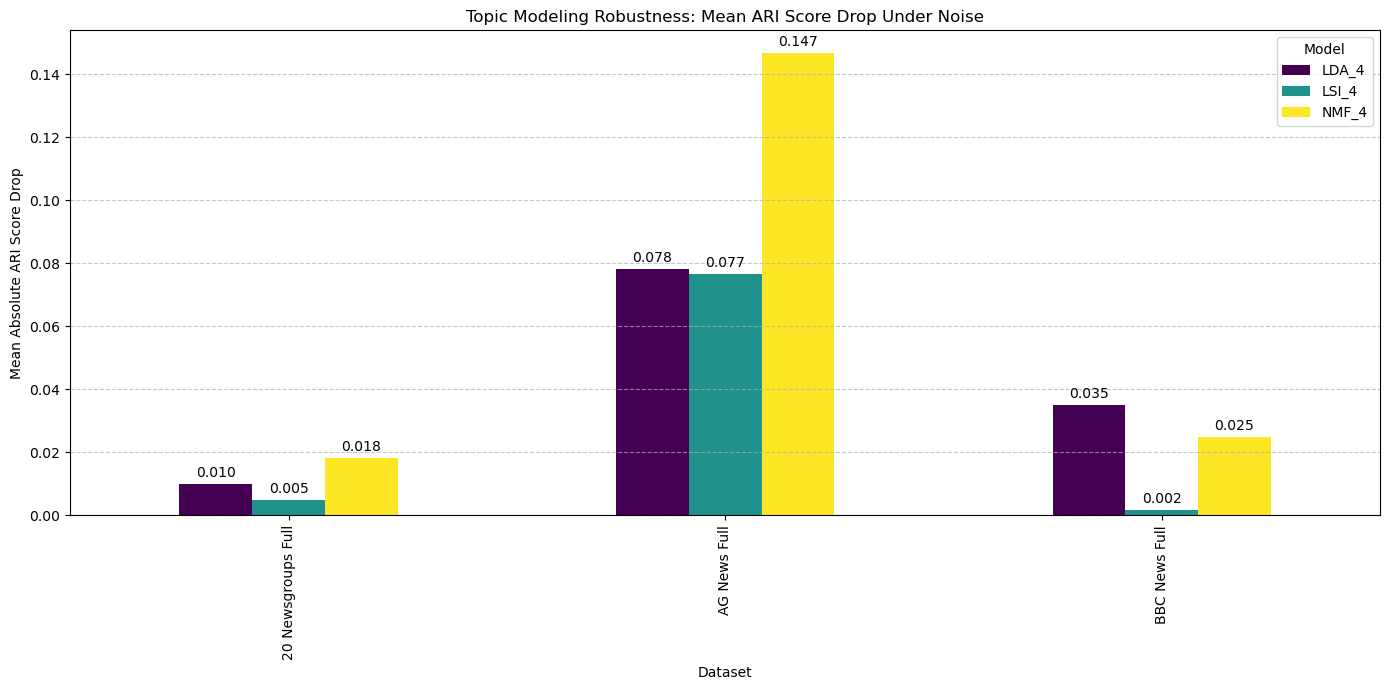

In [78]:
def plot_topic_modeling_robustness(data=None, metric='ARI Score', datasets_order=None, title=None):
    """
    Creates a bar plot showing the average drop in performance metrics when noise is applied
    for different topic modeling approaches.
    
    Parameters:
    -----------
    data : pandas DataFrame
        DataFrame containing topic modeling results
    metric : str, default='ARI Score'
        Metric to analyze for robustness (e.g., 'ARI Score', 'Topics Coherence')
    datasets_order : list, optional
        List specifying the order of datasets to display
    title : str, optional
        Title for the chart
    """
    if data is None:
        data = topics_results
        
    # Determine dataset order
    all_datasets = sorted(data['Dataset'].unique())
    datasets = all_datasets if datasets_order is None else [d for d in datasets_order if d in all_datasets]
    
    # Get models
    models = sorted(data['Model'].unique())
    
    # Compute mean absolute drop per dataset and model
    records = []
    
    for dataset in datasets:
        for model in models:
            # Get clean performance per dataset and model
            clean = data[(data['Noise'] == 'NoNoise') & 
                         (data['Model'] == model) & 
                         (data['Dataset'] == dataset)][metric].values
                         
            if len(clean) == 0:
                continue
                
            clean_val = clean[0]
            
            # Get noisy performance
            noisy = data[(data['Model'] == model) & 
                        (data['Dataset'] == dataset) & 
                        (data['Noise'] != 'NoNoise')][metric]
                        
            if len(noisy) == 0:
                continue
                
            # Calculate mean absolute drop
            drop = np.mean(np.abs(noisy - clean_val))
            records.append({
                'Dataset': dataset, 
                'Model': model, 
                'Mean Absolute Drop': drop
            })
    
    drop_df = pd.DataFrame(records)
    
    # Plot setup
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Pivot data for plotting
    pivot = drop_df.pivot(index='Dataset', columns='Model', values='Mean Absolute Drop')
    
    # Plot as grouped bar chart
    pivot.plot(kind='bar', ax=ax, colormap='viridis')
    
    # Enhance plot
    plt.title(title or f'Robustness to Noise: Mean Absolute {metric} Drop by Dataset and Model')
    plt.xlabel('Dataset')
    plt.ylabel(f'Mean Absolute {metric} Drop')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Model')
    
    # Add values on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
        
    plt.tight_layout()
    plt.show()
    
    return drop_df

# Example usage
robustness_by_dataset_model = plot_topic_modeling_robustness(
    metric='ARI Score',
    datasets_order=['BBC News Full', 'AG News Full', '20 Newsgroups Full'],
    title='Topic Modeling Robustness: Mean ARI Score Drop Under Noise'
)